# Kaggle Mini-Project BBC News

For this mini project I'll be assesing the NMF (Non-Negative Matrix) module to make predictions on the category of certain articles from the BBC News using the module to set up the features according to the text entries of each article.

You can find more information about the competition and sets used here [Kaggle Competition: BBC News Classification](https://www.kaggle.com/c/learn-ai-bbc/overview) and review this project on my GitHub [here](https://github.com/rorrostieta/BBC_News) you can reach out there or ping me for any clarification regarding the project.

## Objective
*"Classify the news articles depending on their content"* This alongside testing various models to see how each one of them perform and compare **NMF** with other supervised models.

## Libraries and Resources
For this project we're given by the competition a test sets to be evaluated I'll be exploring them to give you more context about the problem and my approach.

In [21]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Exploratory Data Analysis

For this part we can see that the set is simple, `ArticleId`, `Text` and `Category`. Since we want our approach to be an unsupervised learning model we will use the `Category` field only as tool to evaluate accuracy of the method.

Let's begin!

In [22]:
df = pd.read_csv('.data/BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<AxesSubplot:>

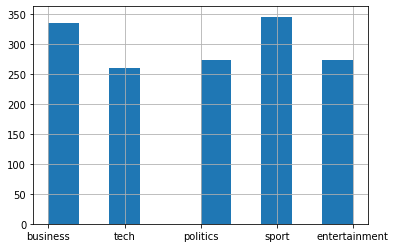

In [24]:
df['Category'].hist()

<AxesSubplot:>

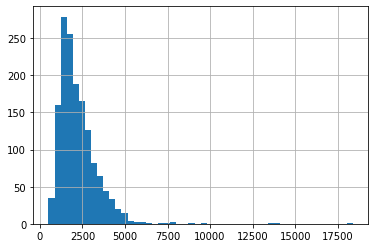

In [25]:
df['Text'].str.len().hist(bins=50)

In [26]:
text_df = df.groupby('Category')['Text'].apply(','.join).reset_index()
text_split = text_df['Text'].str.split()

for i in range(len(text_split)):
    label, counts = np.unique(text_split[i], return_counts=True)
    idx = np.flip(counts.argsort())
    print(text_df['Category'][i])
    print(label[idx][20:50])

business
['from' 'be' 'have' 'are' '-' 'will' 'us' 'which' 'mr' 'but' 'an' 'had'
 'this' 'would' 'been' 'year' 'not' 'more' 'he' 'up' 'were' 'also' 'new'
 'than' 'their' 'firm' 'company' 'last' 'market' 'growth']
entertainment
['-' 'his' 'by' 'will' 'i' 'best' 'have' 'said' 'who' 'from' 'are' 'but'
 'which' 'an' 'also' 'been' 'this' 'had' 'were' 'one' 'not' 'they' 'she'
 'their' 'we' 'us' 'music' 'new' 'year' 'her']
politics
['have' 'not' 'by' 'will' 'with' 'are' 'has' 'they' 'at' 'his' '-' 'from'
 'had' 'labour' 'government' 'an' 'we' 'this' 'i' 'been' 'were' 'people'
 'there' 'their' '.' 'blair' 'which' 'party' 'who' 'election']
sport
['we' 'has' 'be' 'will' 'as' 'not' 'from' 'after' 'by' 'they' 'had'
 'their' 'been' 'said' 'are' 'an' 'this' 'who' 'first' 't' 'against'
 'england' '-' 'out' 'when' 'game' 'win' 'last' 'if' 'over']
tech
['has' 'was' 'they' 'people' 'more' 'not' 'at' 'but' 'which' 'from' 'he'
 'can' 'this' 'or' 'their' 'an' 'its' 'about' 'mr' 'up' 'new' 'also' 'you'
 'we

## EDA Insights and Preprocessing
From the the exploratory analysis we can see how there are 5 main categories for this data set: business, entertainment, politics, sport and tech. We have a good spread of articles each having at least more than 250 entries within their categories which helps by having a less biased data set.

In terms of words er article we can see how we have a lot of articles with around 1500~ words approximately on our raw text files. Here we can see some additional outliers on articles which have more than 5000 words but I have decided not to remove them to see how my models work with the provided sets, maybe these outliers were expected and we're not meant to remove them.

The last part is a small list of most frequent words and I have to say this which you might expect but we have to take into account. The most frequent words in all of the categories were the ones which are commonly used in the language such as prepositions, objects, subjects, etc. hence why I decided to print like from the top 20 to 50 to see some differenciation. Here I see how for business we begin to see words such as *market* or *company* on the top, other examples would be *game* for sport, *election* for politics and *music* for entertainment.

### What about Preprocessing?
For the project I have decided to avoid as much preprocessing as possible to see how the models could be tunned. Text preprocessing can be helpful but they add some kind of bias which I might not expect being a non-native speaker. I might remove some punctuation, accents, tildes and many more features which add context to the language.

With all of this in mind, lets see how the model performs.

## Text Processing Method
The method I chose to process the text is the **TF-IDF** short for **Term Frequency-Inverse Document Frequency** I'll try to summarize the method and how it works to process the text. The first part is the term frequency which measures the amount of times a word/term appears in a document and sets a weight to that term depending on the count. On the other hand the inverse document frequency helps to reduce the weight of very common words which appear in the document, this part sets the weights of terms that appear very frequenly in many documents and the ones that occur rarely. All of this makes this method evaluate which words are specifically mentioned within documents considering that within the language there are a lot of others that support ideas but are not key to vectorize a document.

This process helps to assign the text some weights which we can consider as features for our model. In this case the Non-Negative Matrix Factorization we can input this matrix.

## Support Functions

In [27]:
def predict(W):
    sortedW = np.argsort(W)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

def labels_accuracy(ytdf,yp,n=5):
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['business', 'tech', 'politics', 'sport', 'entertainment']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 5:
                conditions = [
                    (ytdf['Category'] == current['business']),
                    (ytdf['Category'] == current['tech']),
                    (ytdf['Category'] == current['politics']),
                    (ytdf['Category'] == current['sport']),
                    (ytdf['Category'] == current['entertainment'])]
                ytdf['test'] = ytdf['Category'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

## Text Preprocessing and Model Training
Here I tested multiple parameters, here in the TF-IDF from Sklearn we can inout various ways to extract the text, whether its without any kind of puntuaction, max number of features or ngram_range which consider word combinations as features since some phrases might be unique to the category of article we're trying to extract the features from.

For this scenario after using the word verctorizer method we can now input the data into the model and look for the best parameters to obtain a good training score. The key parameters I'm playing with are the beta loss and the solver hyperparameters which slightly impact the final results. 

In [37]:
tfidf = TfidfVectorizer(min_df=3, ngram_range=(1,2), binary=True)
features = tfidf.fit_transform(df.Text)
mod = NMF(n_components=5, solver='mu', beta_loss='kullback-leibler').fit(features)

In [38]:
y = predict(mod.transform(features))
label_order, accuracy = labels_accuracy(df, y )
print(label_order, accuracy)
df.head()

(0, 4, 2, 1, 3) 0.9577181208053691


,ArticleId,Text,Category,test,best
0,1833,worldcom ex-boss launches defence lawyers defe...,business,4,0
1,154,german business confidence slides german busin...,business,4,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,4,0
3,1976,lifestyle governs mobile choice faster bett...,tech,3,4
4,917,enron bosses in $168m payout eighteen former e...,business,4,0


## Model Testing
Ater achieving a good model fit we then need to see how the model performs on the provided test data. First we need to set up the test data the same way the train was in order for the model to be interpreted, in our case since the competition provides separate solution and tests we merge them for the function we had previously to work on the data and check the accuracy correcly.

In [30]:
test_data = pd.read_csv('.data/BBC News Test.csv')
sol = pd.read_csv('.data/BBC News Sample Solution.csv')
df_test = test_data.merge(sol, on='ArticleId')

In [40]:
features_test = tfidf.transform(test_data.Text)
y_test = predict(mod.transform(features_test))
label_order_test, accuracy_test = labels_accuracy(df_test, y_test )
print(label_order_test, accuracy_test)
df_test.head()

(1, 2, 4, 0, 3) 0.24489795918367346


,ArticleId,Text,Category,test,best
0,1018,qpr keeper day heads for preston queens park r...,sport,1,0
1,1319,software watching while you work software that...,tech,3,2
2,1138,d arcy injury adds to ireland woe gordon d arc...,business,4,1
3,459,india s reliance family feud heats up the ongo...,entertainment,0,0
4,1020,boro suffer morrison injury blow middlesbrough...,politics,2,4


## NMF Results
Looking into our results we can see how despite us achieving a 0.95 accuracy on the training data we only have a 0.24 accuracy on our test data which we could say the model does not perform that well. This might be involved with how we're vectorizing the text features or tunning the model to the point where it overfits on the training sets and does not perform as well on the test set.

In the future I might need to use other methods of text vectorizing and see how it performs on this exact NMF model, to discard any issues with how the vectorizing is being done.

# Supervised Model Comparison
For this project I'm going to see how our NMF model fares against a supervised model since we're provided the labels in the competition.

For this part I have selected an ensemble method (Random Forest) and a support vector machine (SVC) to see their performance and compare them in a final analysis to define which method was the most adequate one. I'll be using the same feature matrix we obtained with the TF-IDF method just to be fair to these methods and have a better comparison on the performance of both.

In [32]:
features = tfidf.fit_transform(df.Text).toarray()
labels = df.Category
test_features = tfidf.transform(df_test.Text).toarray()
test_labels = df_test.Category

RF_mod = RandomForestClassifier(n_estimators=150, max_depth=4).fit(features, labels)
SVC_mod = SVC().fit(features, labels)

In [33]:
RF_pred_labels = RF_mod.predict(features)
SV_pred_labels = SVC_mod.predict(features)

ac_RF = accuracy_score(labels, RF_pred_labels)
ac_SV = accuracy_score(labels, SV_pred_labels)

print('Random Forest Classifier:', ac_RF)
print('Support Vector Machine (Classifier):', ac_SV)

Random Forest Classifier: 0.8711409395973154
Support Vector Machine (Classifier): 1.0


In [34]:
RFtest_pred_labels = RF_mod.predict(test_features)
SVtest_pred_labels = SVC_mod.predict(test_features)

ac_RF = accuracy_score(test_labels, RFtest_pred_labels)
ac_SV = accuracy_score(test_labels, SVtest_pred_labels)

print('Random Forest Classifier:', ac_RF)
print('Support Vector Machine (Classifier):', ac_SV)

Random Forest Classifier: 0.19591836734693877
Support Vector Machine (Classifier): 0.18639455782312925


## Analysis
When comparing the supervised models agasint the unsupervised ones we see two key insights:
* Some supervised models can overfit much more easily
* Unsupervised models seem more flexible when test data is added

With those two core ideas we can see how an SVC model overfits on the train data having a accuracy of 1 but when test data is added to the equation we obtain the lowest accuracy of all of the models analyzed. Either way the supervised methods did not return better results compared to the unsupervised which leads us to say that with the available information for this text classification problem a unsupervised model works better than the supervised ones.

## Conclusion
To conclude this project I'll sumarrize into the following bullet points:
* Text vectorization matters

How we decide to translate text features to vectors/matrices is key since these are the inputs to our models, changing the vectorizing method might drastically impact the final result of the model.

* Problem Context Matters

Knowing the type the problem is key to define if we can do suprvised or unsupervised learning. In our case unsupervised showed better performance but this could change if the nature of the problem is different, text analysis and classification might be a good case where it might be better to not know the outcome whereas a problem where we have quantitative attributes a supervised model might return better results, we need to test all the tools available to see which one is the best for out case since there is not a one size fits all solution.

This would be the key points I'd like to share with you, if you have any feedback or comments feel free to reach out on GitHub or other platforms to see how this work can be improved.